# PyESAPI: 10x Research
*By Michael.Folkerts@varian.com*

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from time import time

import pyesapi
import atexit
app = pyesapi.CustomScriptExecutable.CreateApplication('python_demo')
atexit.register(app.Dispose);

## Computing DVH with Structure Masks
* open a plan
* get and plot dose at a slice
* get structure masks
* get and plot dose in each structure at a slice
* compute and plot DVH, compare to Eclipse DVH

In [2]:
# find a prostate patient
for pat in app.PatientSummaries:
    print(pat.Id, pat.LastName, pat.FirstName)

007 Doe John
CSI_01 Demo CSI_01
EC-034 Brain mets Multiple
Eclipse 07 HyperArc Brain
Eclipse 11 MCO Brain
Eclipse 06 MCO Head_Neck
zz_cerv_nod_5 zz_cerv_nod_5 
RapidPlan-01 RapidPlan Prostate T1cN0M0 PSA21.6 G7
RapidPlan-03 RapidPlan HN 3 PTV
PH PHA QUA
Civco_couch Civco Couch
Encompass Encompass SRS
Sinmed Sinmed Couch
VSS 06 Brain Mets 4 mets, CT-MR
VSS 07 Brain Mets 12 Met, CT-MR
Eclipse-03 Head and Neck Two PTV's
Eclipse-04 Lung Right Upper
RapidPlan-02 RapidPlan ProstateNodes T2cN0M0
RapidPlan-04 RapidPlan HN 3 PTV
RapidPlan-06 RapidPlan Lung LUL
Registration 2 Registration Brain CT-MR
Registration 5 PET CT to Plan CT Deformable
Registration 6 Prostate Target Registration Error
SmartSeg 1 Prostate T2 N0 M0 PSA8 GS8
SmartSeg 2 Tonsil T3 N2b M0 right
SmartSeg 3 Nasopharynx T2 N2 M0 right
SmartSeg 4 Rectum T3 N1 M0
Eclipse-01 4D Lung PET CT
Registration 1 Head and Neck CT and CBCT
Registration 3 HeadNeck CT MRI
VSS 01 Spine T6 and T11, CT-MR
VSS 02 Lung RT and LT Lesions, CT
VSS 04 B

In [3]:
app.ClosePatient()
patient = app.OpenPatientById('RapidPlan-01')
plan = patient.CoursesLot('C1').PlanSetupsLot(0)
structures = plan.StructureSet.StructuresLot()
print(f'plan id: {plan.Id}\nstructure set id: {plan.StructureSet.Id}')

plan id: RA Calc
structure set id: Prost30Oct2012


In [4]:
voxels = plan.Dose.np_voxel_locations()  # a pyesapi extension!
print(voxels[0,0,0])

[-292.095066   -81.8581081 -219.000031 ]


In [5]:
# let's grab some structure masks using pysapi extension method
# this is actually a little slow, but worth the wait... (better impemented in c++ and added to ESAPI)
masks = {}
tic = time()
for s in structures:
    print(f"Creating mask for {s.Id} at Dose grid resolution...")
    masks[s.Id] = plan.Dose.np_structure_mask(s)  # pysapi extension!
print(f"Creating structure masks took {time()-tic:0.2f} s")

tic = time()
dose = plan.Dose.np_array_like()  # pysapi extension! (Dose at Dose grid resolution, default)
#dose = plan.Dose.np_array_like(plan.StructureSet.Image)  # pysapi extension! (Dose at CT Image resolution)
print(f"Extracting dose took {time()-tic:0.2f} s")

Creating mask for External at Dose grid resolution...
Creating mask for Bladder at Dose grid resolution...
Creating mask for CTV Prostate at Dose grid resolution...
Creating mask for z CouchInterior at Dose grid resolution...
Creating mask for FemoralHead_L at Dose grid resolution...
Creating mask for Bowel at Dose grid resolution...
Creating mask for FemoralHead_R at Dose grid resolution...
Creating mask for Rectum at Dose grid resolution...
Creating mask for z CouchSurface at Dose grid resolution...
Creating mask for CTV+margin at Dose grid resolution...
Creating mask for PTV at Dose grid resolution...
Creating structure masks took 27.50 s
Extracting dose took 0.35 s


(238, 128, 189)


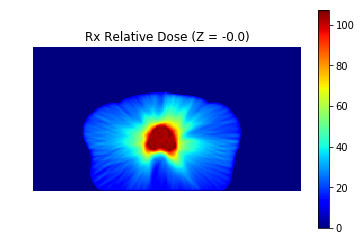

In [6]:
slice_idx = 73
print(dose.shape)

slice_z_mm = voxels[0,0,slice_idx][2]  # a 3D array of 3D points of locations for each voxel

plt.imshow(dose[:,:,slice_idx].T,interpolation=None,cmap='jet')  # indexed as [x,y,z], transpose needed for imshow
plt.axis('off')
plt.colorbar()
plt.title("Rx Relative Dose (Z = {:.1f})".format(slice_z_mm))
plt.show()

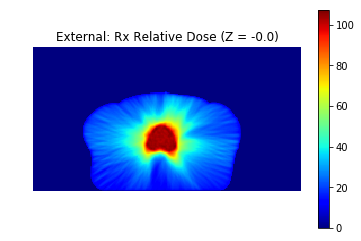

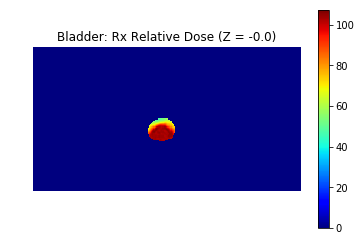

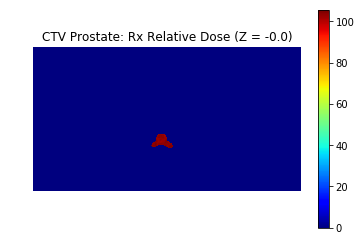

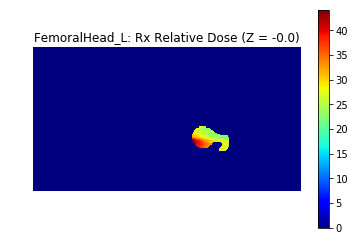

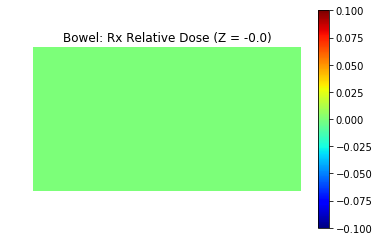

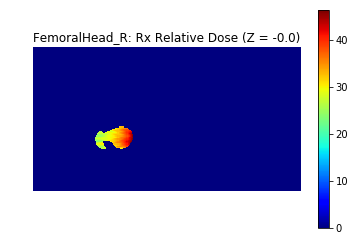

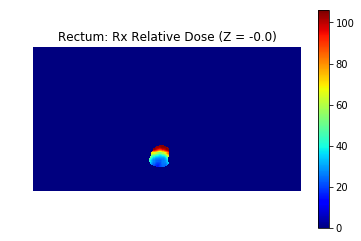

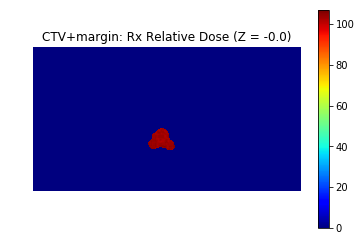

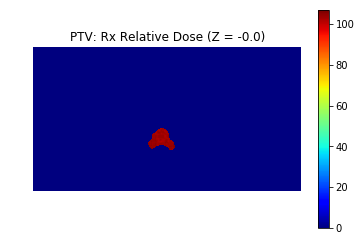

In [7]:
# plot dose in each organ

skip_structureIds = ["z CouchSurface", "z CouchInterior"]

for sId, mask in masks.items():
    if sId in skip_structureIds:
        continue
    plt.imshow((mask[:,:,slice_idx]*dose[:,:,slice_idx]).T,interpolation=None,cmap='jet')  # indexed as [x,y,z], transpose needed for imshow
    plt.axis('off')
    plt.colorbar()
    plt.title(f'{sId}: Rx Relative Dose (Z = {slice_z_mm:.1f})')
    plt.show()

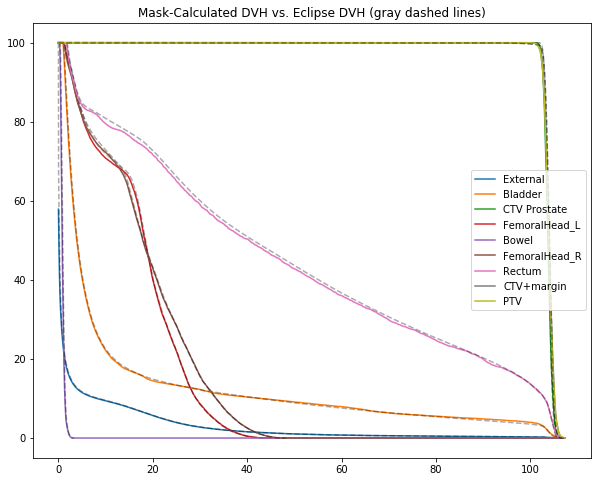

In [8]:
import numpy as np
# let's compute some DVH "by hand" and compare to Eclipse
plt.figure(figsize=(10,8))
for sId, mask in masks.items():
    mask_idx = np.where(mask)
    tot_vox = np.ones_like(dose)[mask_idx].sum()
    hist,bins = np.histogram(dose[mask_idx].flatten(),bins=1000,range=(0,dose.max()))
    
    if tot_vox == 0:
        continue # skip
    
    plt.plot(bins[:-1],100.-hist.cumsum()*100.0/tot_vox,label=sId)
    dvh = plan.GetDVHCumulativeData(
        structures[sId],
        pyesapi.DoseValuePresentation.Relative,
        pyesapi.VolumePresentation.Relative,
        .01
    )
    
    if dvh is None:
        continue # skip

    pts = np.array([[p.DoseValue.Dose,p.Volume] for p in dvh.CurveData])
    plt.plot(pts[:,0],pts[:,1],'k--',alpha=.33)

plt.legend(loc=0)
plt.title("Mask-Calculated DVH vs. Eclipse DVH (gray dashed lines)")
plt.show()

## Custom Fluence Map Optimization (Time Permitting else Demo)
* create a plan
* create beams
* fit jaws to PTV
* calculate open field dose
* create dose-influence matrix
* create Rx distibution
* solve simple least squares optimization
* set fluence
* calculate dose
* view in eclipse

In [9]:
# let's make a plan
# start by creating a new course
patient.BeginModifications()
new_course = patient.AddCourse()
new_course.Id = 'MyExperiment23' # use random number

In [10]:
new_plan = new_course.AddExternalPlanSetup(plan.StructureSet)

In [11]:
beam_angles = [0,50,110,200,260]
collimator_angle = 0.0
couch_angle = 0.0
isocenter = plan.BeamsLot(0).IsocenterPosition
jaw_positions = pyesapi.VRect[float]() # X1=X2=Y1=Y2=0.0, we will fit them later
external_beam_machine = pyesapi.ExternalBeamMachineParameters(
    'TrueBeam',
    '6X',
    600,
    "STATIC",
    None  # primaryFluenceModeId: "SRS", "FFF"
)
ptv_structure = new_plan.StructureSet.StructuresLot("PTV")

In [12]:
for beam_angle in beam_angles:
    new_beam = new_plan.AddStaticBeam(
        external_beam_machine,
        jaw_positions,
        collimator_angle,
        beam_angle,
        couch_angle,
        isocenter
    )
    new_beam.Id = str(beam_angle)
    new_beam.FitCollimatorToStructure(
        pyesapi.FitToStructureMargins(5.0), # JAW_FIT_MARGIN_MM
        ptv_structure,
        True, # asymmetric X jaws
        True, # asymmetric Y jaws
        False # optimize collimator angle
    )

In [13]:
# calculate open field dose
# takes about 30 sec
tic = time()
assert new_plan.CalculateDose().Success
print(f"Dose Calc Time: {time()-tic:.1f} sec")

Dose Calc Time: 27.7 sec


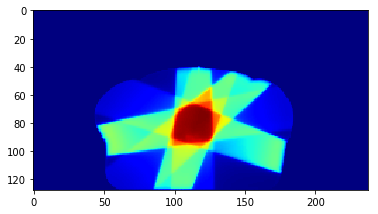

In [14]:
open_field_dose = new_plan.Dose.np_array_like()

plt.imshow(open_field_dose[:,:,slice_idx].T,interpolation=None,cmap='jet')  # indexed as [x,y,z], transpose needed for imshow
plt.show()

In [15]:
app.SaveModifications()